# 📘 analise_exploratoria
### **Objetivo:**
- Identificar padrões e relações entre presença, partidos e eventos.

In [ ]:
import pandas as pd
import json
from pathlib import Path

DIR = "../data/processed/"

# 1) Deputados
deputados = pd.read_json(DIR + "deputados.json", dtype=False)
deputados["id"] = deputados["id"].astype("int64")
deputados["siglaPartido"] = deputados["siglaPartido"].astype("string")
deputados["siglaUf"] = deputados["siglaUf"].astype("string")
deputados["idLegislatura"] = deputados["idLegislatura"].astype("int64")

# 2) Frequência de eventos (proxy)
freq_eventos = pd.read_csv(
    DIR + "freq_eventos.csv",
    dtype={"id_deputado":"Int64","num_eventos":"Int64"}
)

# 3) Votos por deputado (forçar strings e normalizar depois)
votos = pd.read_csv(
    DIR + "votos_deputados.csv",
    dtype={
        "id_votacao": "string",
        "id_deputado": "Int64",
        "tipo_voto": "string",
        "dataHoraRegistro": "string",
    }
)
# normalizar data/hora (pode vir vazio)
votos["dataHoraRegistro"] = pd.to_datetime(votos["dataHoraRegistro"], errors="coerce")

# 4) Ocupações
ocupacoes = pd.read_csv(
    DIR + "ocupacoes.csv",
    dtype={"id_deputado":"Int64","titulo":"string","dataInicio":"string","dataFim":"string"}
)
for col in ["dataInicio","dataFim"]:
    ocupacoes[col] = ocupacoes[col].replace("-", pd.NA)
    ocupacoes[col] = pd.to_datetime(ocupacoes[col], errors="coerce")

# 5) Eventos de sessões (padronizar datas e tipos nullable)
eventos = pd.read_csv(
    DIR + "eventos_sessoes.csv",
    dtype={"id_evento":"Int64","dataHoraInicio":"string","dataHoraFim":"string","id_orgao":"float64","descricaoTipo":"string"}
)
eventos["dataHoraInicio"] = pd.to_datetime(eventos["dataHoraInicio"], errors="coerce")
eventos["dataHoraFim"]    = pd.to_datetime(eventos["dataHoraFim"], errors="coerce")
eventos["id_orgao"] = eventos["id_orgao"].astype("Int64")  # nullable

# 6) Situações (JSON referência)
with open(DIR + "cod_situacao_deputados.json", "r", encoding="utf-8") as f:
    cod_situacao_raw = json.load(f)
df_situacao = (
    pd.DataFrame(cod_situacao_raw.get("dados", cod_situacao_raw))
      .rename(columns={"cod":"codigo","sigla":"sigla","nome":"nome","descricao":"descricao"})
)
for c in ["codigo","sigla","nome","descricao"]:
    if c in df_situacao.columns:
        df_situacao[c] = df_situacao[c].astype("string")

print("✅ Leitura & tipos ajustados.")


/home/nemo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


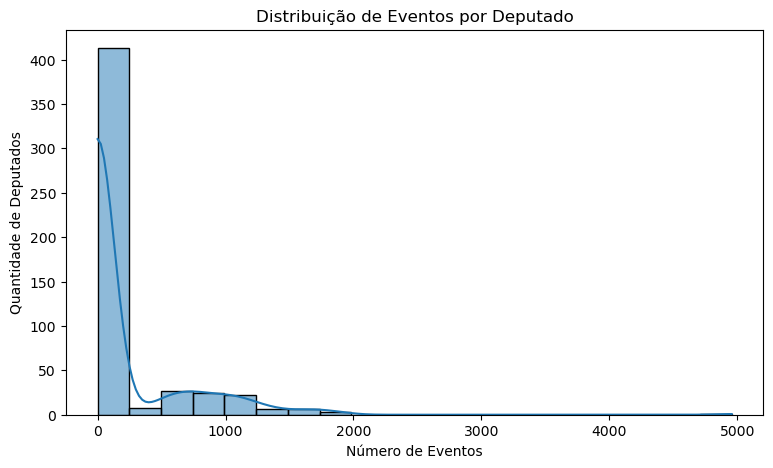

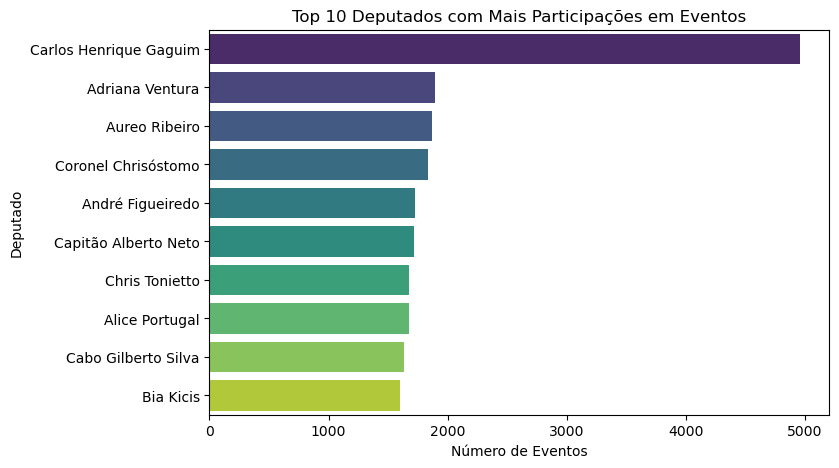